In [1]:
import tensorflow as tf 
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt 


In [3]:
pip install --upgrade protobuf


Note: you may need to restart the kernel to use updated packages.


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Potato",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1500 files belonging to 3 classes.


In [4]:
len(dataset)

47

In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

#32	32 images in this batch
#256	image height (pixels)
#256	image width (pixels)
#3	RGB color channels

(32, 256, 256, 3)
[0 2 1 2 2 0 1 2 1 0 0 1 2 1 2 1 2 0 0 2 1 1 1 2 1 0 2 2 2 1 2 1]


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

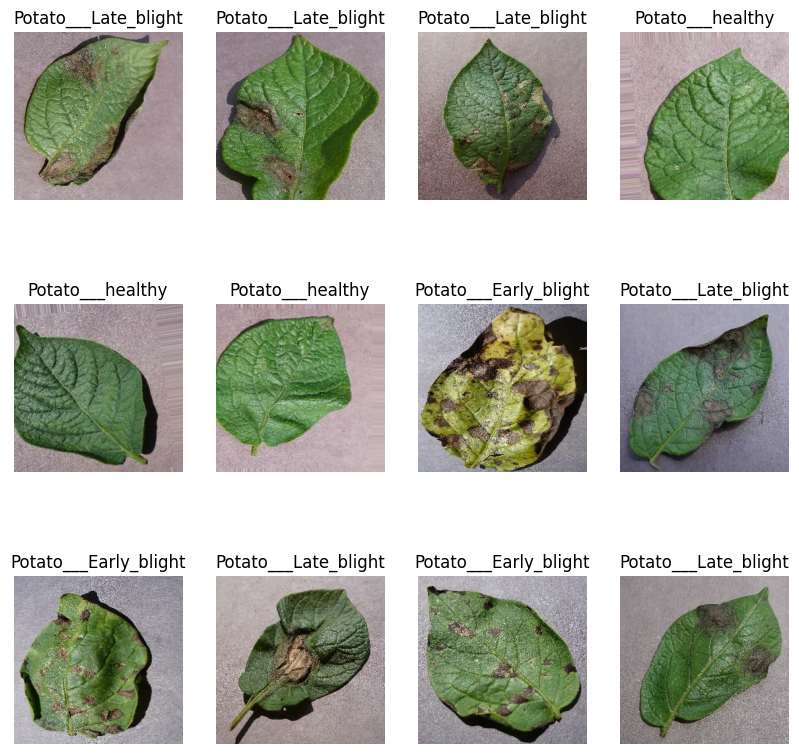

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8')) #plot the image 
        plt.title(class_names[label_batch[i]])
        #print(image_batch[i].shape)   #first image shape 
        plt.axis("off")

In [8]:
len(dataset)

47

80% for training
20% for validation and test


In [9]:
train_size = 0.8
len(dataset)*train_size

37.6

In [10]:
train_ds = dataset.take(52)
len(train_ds)

47

In [11]:
test_ds = dataset.skip(52)
len(test_ds)

0

In [12]:
val_size=0.1
len(dataset)*val_size

4.7

In [13]:
val_ds= test_ds.take(6)
len(val_ds)

0

In [14]:
test_ds= test_ds.skip(6)
len(test_ds)

0

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)      # mixing your data randomly so that the order does not bias your model.
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [17]:
print(len(train_ds)) 
print(len(val_ds))
print(len(test_ds))



37
4
6


In [18]:
#Cache, Shuffle, and Prefetch the Dataset


train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


1. Why do we need a resizing layer?

Neural networks expect all input images to be the same size.

During training, your images might already be (256, 256), but when the model is deployed:

Users might upload images of any size, e.g., (300, 400) or (128, 128)

By adding a resizing layer in the model, you ensure all incoming images are automatically resized to (256, 256) for the network.

✅ This avoids errors during prediction and makes the model more robust.

2. Why normalize?

Pixel values in images range from 0 to 255.

Neural networks learn faster and perform better when input values are small, usually between 0 and 1.

Normalization is done by dividing each pixel by 255.

Example: A pixel value of 128 → 128 / 255 ≈ 0.502

By adding normalization as a layer, it works for both training and inference, so you don’t need to manually preprocess images later.

3. Why put resizing & normalization as a layer in the model?

Makes your model self-contained

You can feed any image to the model without preprocessing it manually

Ensures consistency between training and prediction

==> Resizing ensures all images have the same shape, normalization scales pixel values for better learning, and including these as model layers makes the model robust for training and future predictions.

In [19]:
from tensorflow.keras import layers, Sequential

resize_and_rescale = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),   # Resize images
    layers.Rescaling(1./255)                   # Normalize pixels
])


Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [21]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\SBS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


This prepares your model for training.

Compilation tells TensorFlow:

How to update the weights (optimizer)

How to measure error (loss function)

What performance metric to track (accuracy)

🔹 1️⃣ Optimizer: adam
python
Copier le code
optimizer='adam'
Optimizer decides how the model learns during training

Adam = Adaptive Moment Estimation

Combines momentum + adaptive learning rate

Works well in almost every case

Think: it automatically adjusts step sizes to reach the best weights faster

🔹 2️⃣ Loss function: SparseCategoricalCrossentropy
python
Copier le code
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
Measures how wrong the model is

“Categorical” → used for multi-class classification

“Sparse” → your labels are integers (0, 1, 2), not one-hot vectors [1,0,0]

from_logits=False → your model already uses softmax, so outputs are probabilities (0–1)

In short:

The model compares predicted probabilities to the true class and calculates the error.

🔹 3️⃣ Metric: accuracy
python
Copier le code
metrics=['accuracy']
Tracks percentage of correct predictions

Useful to see how well the model is doing during training

Accuracy = (# correct predictions) / (total predictions)

 note
We compile the model to prepare it for training:

Optimizer: adam → updates weights efficiently

Loss: SparseCategoricalCrossentropy → measures error for integer class labels

Metric: accuracy → tracks correct predictions

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 23s 553ms/step - accuracy: 0.3542 - loss: 1.0806 - val_accuracy: 0.4922 - val_loss: 1.0173
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 569ms/step - accuracy: 0.4280 - loss: 1.0365 - val_accuracy: 0.4844 - val_loss: 1.0138
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 23s 616ms/step - accuracy: 0.6636 - loss: 0.7348 - val_accuracy: 0.8359 - val_loss: 0.4086
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 22s 578ms/step - accuracy: 0.7297 - loss: 0.5588 - val_accuracy: 0.8359 - val_loss: 0.3977
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 546ms/step - accuracy: 0.7949 - loss: 0.4364 - val_accuracy: 0.8125 - val_loss: 0.4507
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 540ms/step - accuracy: 0.8831 - loss: 0.2876 - val_accuracy: 0.7734 - val_loss: 0.6413
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 553ms/step - accuracy: 0.8966 - loss: 0.2722 - val_accuracy: 0.9375 - val_loss: 0.1451
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 517ms/step - accuracy: 0.9559 - loss: 0.1382 - val_accu

In [25]:
scores = model.evaluate(test_ds)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.3438 - loss: 1.1033


In [26]:
scores


[1.1032609939575195, 0.34375]

Plotting the Accuracy and Loss Curves

In [27]:
history.params


NameError: name 'history' is not defined

In [ ]:
history.history.keys()


loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [28]:
type(history.history['loss'])


NameError: name 'history' is not defined

In [29]:
len(history.history['loss'])


NameError: name 'history' is not defined

In [30]:
history.history['loss'][:5] # show loss for first 5 epochs


NameError: name 'history' is not defined

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

NameError: name 'history' is not defined

NameError: name 'acc' is not defined

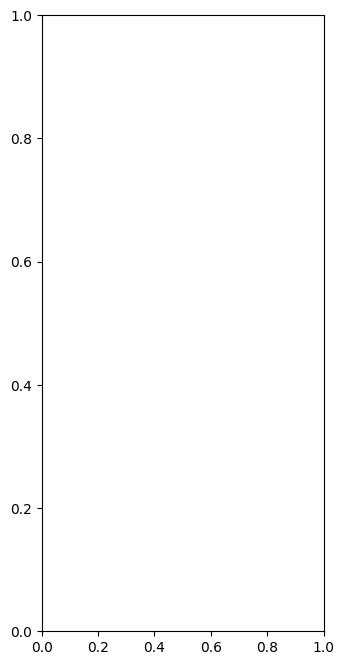

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
predicted label: Potato___healthy


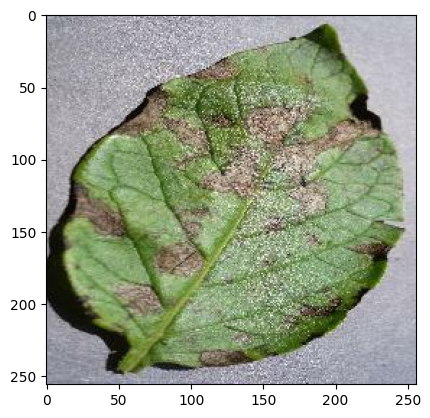

In [33]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [34]:
#Function for Inference 
#Shows how the model performs on completely unseen data.

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


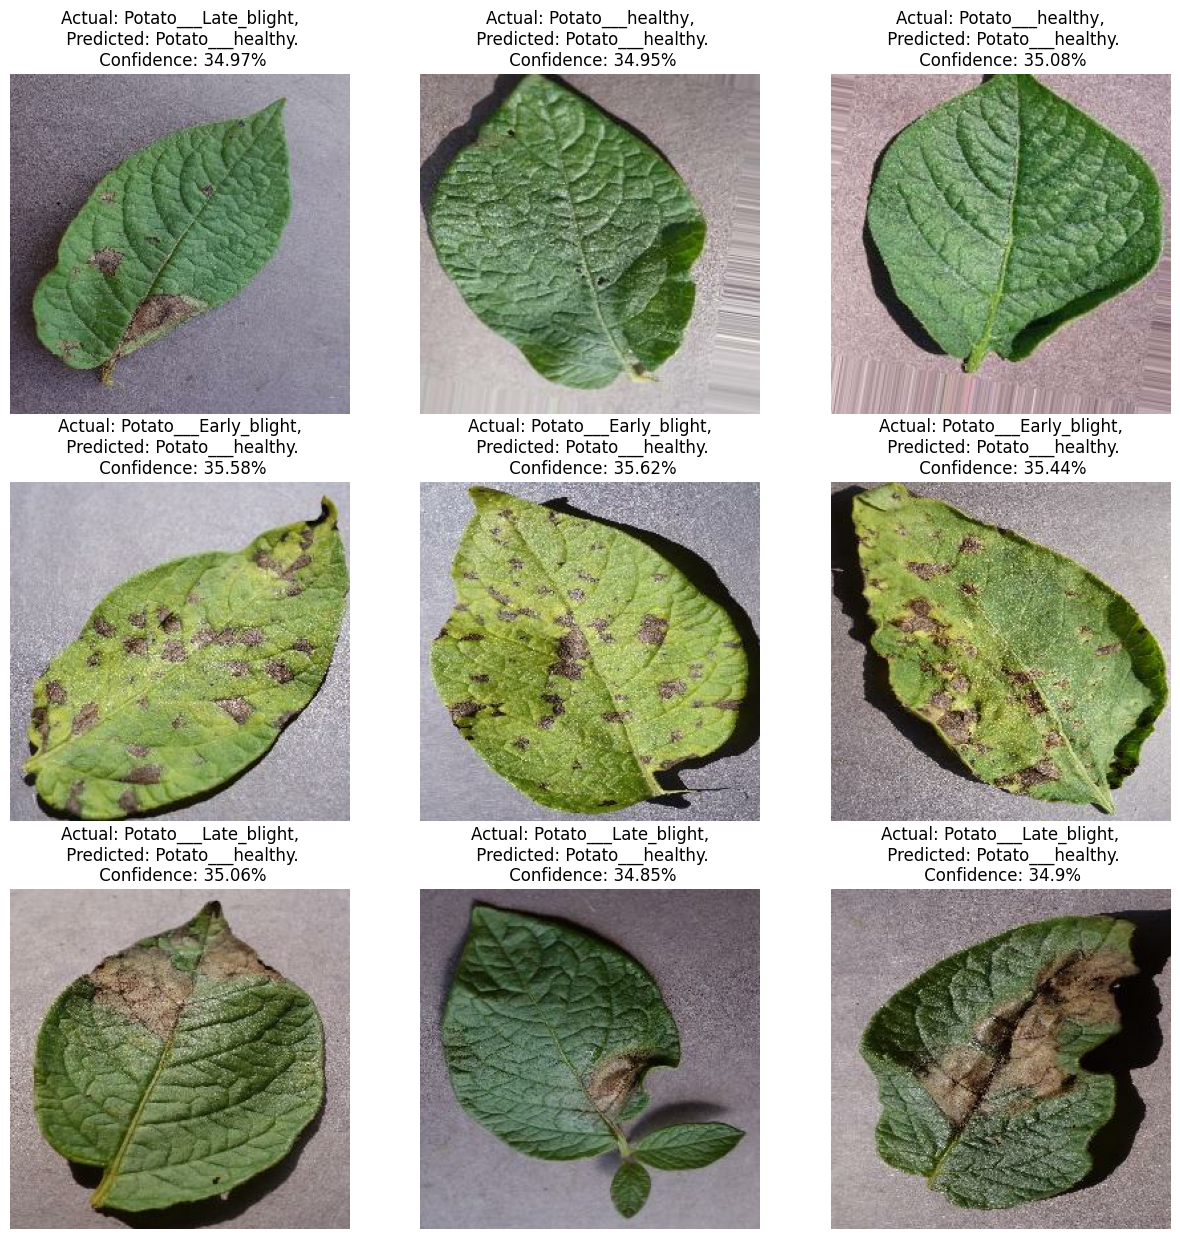

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [36]:
import os

models_dir = "../models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

existing_versions = [int(i.split('.')[0]) for i in os.listdir(models_dir) if i.split('.')[0].isdigit()]
model_version = max(existing_versions + [0]) + 1

# Save as .keras file
model_path = f"{models_dir}/{model_version}.keras"
model.save(model_path)
print(f"Model saved as file: {model_path}")


Model saved as file: ../models/4.keras


In [42]:
import os
import tensorflow as tf

# Suppose this is your trained Keras model
# model = ...

models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

# Automatically find next version number
existing_versions = [int(d) for d in os.listdir(models_dir) if d.isdigit()]
model_version = max(existing_versions + [0]) + 1

# Folder path for this version
version_path = os.path.join(models_dir, str(model_version))

# Export the model in TF SavedModel format (Keras 3)
model.export(version_path)

print(f"Model exported in folder (TF Serving ready): {version_path}")


INFO:tensorflow:Assets written to: ../models\1\assets


INFO:tensorflow:Assets written to: ../models\1\assets


Saved artifact at '../models\1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2150640144976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2150640142288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2150640148048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2150640143056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2150640147856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2150640147664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2150640145168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2150640145552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2150640144592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2150640142864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2150640145360: TensorSpec(shape=(), dt